In [1]:
#Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import ast 
import scipy.stats as stats
import math
import seaborn as sns


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm
from sympy import symbols, integrate, lambdify, diff
import scipy.integrate as spi
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans


from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import DBSCAN
### PCA Analysis
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA



### Define Dataset to conduct analysis on: 

In [2]:
time_between_frames = 5
initial_exposure = 60
time_between_exposure = 120
num_frames = 276

#framerange = [(0, 25), (25, 50), (50, 75), (75, 100), (100, 300)]
columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]


In [3]:
#experiment = "combined"
#experiment = "M4581_s1"
#experiment = "M4567_s2"
experiment = "M4581_s7"
#experiment = "M4576_s4"
#experiment = "M4576_s7"
#experiment = "M4581_s4"


---
# Analysis 

### Initialization: includes calculating exposure, bin width, and normalization functions

In [4]:
def calculate_exposure(num_frames, initial_exposure, time_between_exposure, time_between_frames) -> list[int]:

  frames_between_exposures = time_between_exposure/time_between_frames
  first_frame_exposure = initial_exposure/time_between_frames - 1

  print(f"first germinant exposure: {first_frame_exposure}")
  print(f"time between germinant exposures: {frames_between_exposures}")

  exposure_frames = [first_frame_exposure]

  while exposure_frames[-1] + frames_between_exposures < num_frames:
    exposure_frames.append(exposure_frames[-1] + frames_between_exposures)

  return first_frame_exposure, frames_between_exposures, exposure_frames

# function call 
first_frame_exposure, frames_between_exposures, germinant_exposures = calculate_exposure(num_frames, initial_exposure, time_between_exposure, time_between_frames)
print(f"Germinant exposures: {germinant_exposures}")

sample_germination_frames = [frame + 2 for frame in germinant_exposures]

first germinant exposure: 11.0
time between germinant exposures: 24.0
Germinant exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0]


Bin Width using (1) Sturges Method (use with small datasets) (2) Scott's Rule normally distributed data (3) Freedman-Diaconis Rule - robust to outliers

In [5]:
def get_bin_width(data, method):  
  if method == "Sturges":
    k = int(np.ceil(np.log2(len(data)) + 1))
    bin_width = (np.max(data) - np.min(data)) / k

  if method == "Scotts":
    bin_width = 3.5 * np.std(data) / (len(data) ** (1/3))

  if method == "Freedman":
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(data) ** (1/3))

  bins = int(np.ceil((data.max() - data.min()) / bin_width))
  return bins

Normalize DataSet: 

In [6]:
def scale_csv_data(file_path: str, columns_to_scale: list[str]):
    data = pd.read_csv(file_path)
    scaler = MinMaxScaler()

    def scale_column(column):
        lists = column.apply(ast.literal_eval)
        flattened = np.concatenate(lists.values)
        scaled_flattened = scaler.fit_transform(flattened.reshape(-1, 1)).flatten()
        scaled_lists = []
        start = 0
        for lst in lists:
            end = start + len(lst)
            scaled_lists.append(scaled_flattened[start:end].tolist())
            start = end
        return [str(lst) for lst in scaled_lists]
    
    for column in columns_to_scale:
        data[column] = scale_column(data[column])

    return data

Datasets:

In [7]:
#M4581_s1
if experiment == "M4581_s1":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv"
  plots_folder= "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M4576_s2
if experiment == "M4576_s2":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4576_s2/M4576_s2_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4576_s2/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#combined datasets
if experiment == "combined":
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s1andM4576_s2/plots/"
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv"
  M4581_s1_scaleddf  = scale_csv_data(csv_path, columns_to_scale)
  csv_path2 = "/Users/alexandranava/Desktop/Spores/M4576_s2/M4576_s2_Model_Data.csv"
  M4576_s2_scaleddf = scale_csv_data(csv_path2, columns_to_scale)
  df = pd.concat([M4581_s1_scaleddf, M4576_s2_scaleddf], axis=0)
  df.reset_index(drop=True, inplace=True)
  combined = 1

#M4581_s7
if experiment == "M4581_s7":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s7/PostProcess_V4/M4581_s7_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s7/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M4576_s4
if experiment == "M4576_s4":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4576_s4/PostProcess_V2/M4576_s4_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4576_s4/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0

#M4576_s7
if experiment == "M4576_s7":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4576_s7/PostProcess_V2/M4576_s7_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4576_s7/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0
#M4581_s4
if experiment == "M4581_s4":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s4/PostProcess_V4/M4581_s4_Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s4/Analysis/Plots/"
  df  = scale_csv_data(csv_path, columns_to_scale)
  combined = 0
data_folder = plots_folder.replace("Plots", "Data")

## Germination Measurement

Adds Germination Frame to df in "GERMINATION_INDEX" column

In [8]:
def add_germination_index(df):
    GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)
    germination_frames_list = GERMINATION.apply(lambda x: x.index(1))

    df["GERMINATION_INDEX"] = germination_frames_list
    #df["GERMINATION_INDEX"] = df["GERMINATION_INDEX"].astype(float)

add_germination_index(df)

Adds germinant exposures before germination to df in "GERMINANT_EXPOSURES" column

In [10]:
def add_germinant_exposures(df):
  EXPOSURE_COLUMN = [] # {exposure number: spores germinated with that exposure}

  for frame_number in df["GERMINATION_INDEX"]:
    exposure_count = math.floor((frame_number - first_frame_exposure)/frames_between_exposures) + 1
    EXPOSURE_COLUMN.append(exposure_count)
  df["GERMINANT_EXPOSURES"] = EXPOSURE_COLUMN
  if experiment in ["M4581_s7", "M4576_s7"]:
      df = df[df["GERMINANT_EXPOSURES"] != 3]
      df = df.reset_index(drop=True)  # Reindex the dataframe
      df.to_csv(csv_path)
  return df

df = add_germinant_exposures(df)

Creates a lineplot of population dormancy, as well as a histogram of germination events

In [ ]:
def germination_frequency(plots_folder: str, df, output: int = 1) -> None:

  germination_frames_list = list(df["GERMINATION_INDEX"])
  frames_shown: int = 189


  GERMINATION = []
  min_frames = 10000
  for row in df["GERMINATION"].apply(ast.literal_eval):
    if len(row)<min_frames:
      min_frames = len(row)

  for row in df["GERMINATION"].apply(ast.literal_eval):
    GERMINATION.append(row[:min_frames])

  bin_size = get_bin_width(np.array(GERMINATION), "Sturges")
  print(f"optimal bin width: {bin_size}")

  #print times frame germination occurs
  frame_counts = Counter(germination_frames_list)
  sorted_frame_counts = sorted(frame_counts.items())

  germination_events: list[int] = []
  percent_germinated_at_t: list[int] = []
  for frame_number, count in sorted_frame_counts:
      if output == 1:
        germination_events.append(count)
  #histogram plot 
  fig, ax1 = plt.subplots()

  #germinant intervals
  ax1.grid(color='silver', linewidth=1, linestyle = "dashed", which = "both", axis = "x")

  #histogram
  sns.histplot(germination_frames_list, bins = bin_size, label = f"Germination Events", ax = ax1, color = "powderblue")
  
  #axis labels 
  ax1.set_xlabel("Frame", fontsize = 16)
  ax1.set_ylabel("Germination Event Frequency", fontsize = 16)

  #x axis limit and ticks
  ax1.set_xlim([0, frames_shown])
 
  #overlaid percentage plot 
  total_spores = sum(count for frame, count in sorted_frame_counts)
  spores_count = total_spores
  frames = [0]
  percents = [100]
  percent_plot = [100]
  frame_dict = dict(sorted_frame_counts)

  total_percent = 100  

  ### by individual frames
  for frame_number in range(1, frames_shown+1):
    if frame_number in frame_dict:
      count = frame_dict[frame_number]
      spores_count -= count
      total_percent = spores_count / total_spores * 100
      t_percent = count/total_spores * 100
      percent_plot.append(total_percent)
      percent_germinated_at_t.append(t_percent)
    percents.append(total_percent)
    frames.append(frame_number)

  #percent plot
  ax2 = ax1.twinx()
  sns.lineplot(x=frames, y=percents, ax = ax2, linestyle = "--", linewidth = 2, label = "Dormant Percentage", color = "tomato")

  #custom germinant label
  ax2.axvline(x=11, color='silver', label='Germinant Exposure', linewidth = 1, linestyle = "dashed")

  #percent y axis formatting
  ax2.set_ylabel("Dormant Percentage", fontsize = 16)
  ax2.set_yticks([0, 25, 50, 75, 100])
  ax2.tick_params(axis='y', labelsize=12)
  ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
  
  #legends
  handles1, labels1 = ax1.get_legend_handles_labels()
  handles2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='best', fontsize=12)

  plt.tight_layout()
  plt.savefig(f"{plots_folder}germination_percentage_{bin_size}bins.jpg")
  plt.clf()
  
  ### Stats
  print(f"Total Spores: {total_spores}")

  ## statistics by frames
  print("\n Statistics by Events:")
  print(f"Frames that events occur: {len(germination_events)}")
  print(f"Frames: {str(list(frame_dict.keys())).replace(',', ' &')}")
  print(f"Germination Events: {str(germination_events).replace(',', ' &')}")
  print(f"Total Percentage: [{' & '.join([f'{elem:.0f}' for elem in percent_plot[1:]])}]")
  print(f"Percentage at frame: [{' & '.join([f'{elem:.0f}' for elem in percent_germinated_at_t[1:]])}]")

  return min_frames
min_frames = germination_frequency(plots_folder, df)

optimal bin width: 8
Total Spores: 107

 Statistics by Events:
Frames that events occur: 6
Frames: [13 & 14 & 37 & 38 & 41 & 86]
Germination Events: [27 & 11 & 62 & 5 & 1 & 1]
Total Percentage: [75 & 64 & 7 & 2 & 1 & 0]
Percentage at frame: [10 & 58 & 5 & 1 & 1]


<Figure size 640x480 with 0 Axes>

Creates a piechart of germinant exposures until germination

In [ ]:
def piechart_germination_exposure(df):
    total_spores = len(df)
    df = df.sort_values(by=['GERMINANT_EXPOSURES'])
    exposures_list = df['GERMINANT_EXPOSURES'].unique()
    value_counts = df['GERMINANT_EXPOSURES'].value_counts()

    #========================GERMINANT EXPOSURE
    ## statistics by germinant exposures
    total_percentage_by_exposure = []
    percentage_at_exposure = []

    total_germinated = 0
    for exposure in exposures_list:
        
        spores_germinated_interval = value_counts[exposure]
        total_germinated += spores_germinated_interval
        total_percentage_by_exposure.append(((total_spores - total_germinated) / total_spores) * 100)

        percentage_at_t = (spores_germinated_interval / total_spores) * 100
        percentage_at_exposure.append(percentage_at_t)

    ### Pie chart by germinant exposures
    labels = [f'$GE_{exposure}$ = {value_counts[exposure] / total_spores * 100 :.2f}%' for exposure in exposures_list]

    plt.clf()
    plt.figure(figsize=(6, 3))
    colors = sns.color_palette('pastel')[0:len(percentage_at_exposure)]

    explode_val = percentage_at_exposure.index(max(percentage_at_exposure))
    explode = [0 for _ in range(len(percentage_at_exposure))]
    explode[explode_val] = 0.1

    plt.pie(percentage_at_exposure, labels=labels, shadow=True, colors=colors, wedgeprops={'edgecolor': 'black'}, startangle=140, explode=explode, pctdistance=1.00, textprops={'fontsize': 16})
    #plt.title("Distribution of Germination Exposures")
    plt.savefig(plots_folder + "piechart_germination_atexposure.jpg")
    plt.clf()

    ## Print stats
    print("\n Statistics by Exposures:")
    print(f"Germinant Exposures: {str(list(exposures_list)).replace(',', ' &')}")
    print(f"Germination Events: {str(list(value_counts)).replace(',', ' &')}")
    print(f"Total Dormancy Percentage: [{' & '.join([f'{elem:.2f}' for elem in total_percentage_by_exposure])}]")
    print(f"Percent Germinated at Exposure: [{' & '.join([f'{elem:.2f}' for elem in percentage_at_exposure])}]")

piechart_germination_exposure(df)


 Statistics by Exposures:
Germinant Exposures: [1 & 2 & 4]
Germination Events: [68 & 38 & 1]
Total Dormancy Percentage: [64.49 & 0.93 & 0.00]
Percent Germinated at Exposure: [35.51 & 63.55 & 0.93]


<Figure size 640x480 with 0 Axes>

<Figure size 600x300 with 0 Axes>

## Feature Analysis

Get minimum and maximum global value of a given feature

In [ ]:
def get_min_max(df, feature: str) -> int:
    data_max = []
    data_min = []
    data = df[feature].apply(ast.literal_eval) 
    for row in data:
        data_max.append(max(row))
        data_min.append(min(row))
    return [min(data_min), max(data_max)]

minmax_intensity: list[int, int] = get_min_max(df, "INTENSITY")
minmax_area: list[int, int] = get_min_max(df, "AREA")
minmax_minor: list[int, int] = get_min_max(df, "ELLIPSE MINOR")
minmax_major: list[int, int] = get_min_max(df, "ELLIPSE MAJOR")
minmax_perimeter: list[int, int] = get_min_max(df, "PERIMETER")
minmax_circularity: list[int, int] = get_min_max(df, "CIRCULARITY")
minmax_aspectratio: list[int, int] = get_min_max(df, "ELLIPSE ASPECT RATIO")

Adds initial feature value, last feature value before germination, and the difference between these two in "INITIAL_{feature}", "LAST_{feature}" and "DIFF_{feature}" columns

In [ ]:
def add_initial_last_measure_feature(df, feature:str):

  FEATURE = df[feature].apply(ast.literal_eval)

  INITIAL_FEATURE_COLUMN = []
  LAST_FEATURE_COLUMN = []
  DIFF_FEATURE_COLUMN = []

  for i in range(len(df)):
    spore_feature = FEATURE[i]
    spore_germination_frame = df.loc[i, "GERMINATION_INDEX"]

    feature_before_germination: list[int] = spore_feature[0: spore_germination_frame]

    initial_feature = np.mean(feature_before_germination[0: 3]) #averaged over first and last frames
    INITIAL_FEATURE_COLUMN.append(initial_feature)
    
    last_feature = np.mean(feature_before_germination[-3: -1])
    LAST_FEATURE_COLUMN.append(last_feature)

    diff_feature = abs(last_feature - initial_feature)
    DIFF_FEATURE_COLUMN.append(diff_feature)

  df[f"INITIAL_{feature}"] = INITIAL_FEATURE_COLUMN
  df[f"LAST_{feature}"] = LAST_FEATURE_COLUMN
  df[f"DIFF_{feature}"] = DIFF_FEATURE_COLUMN


add_initial_last_measure_feature(df, "INTENSITY")
add_initial_last_measure_feature(df, "AREA")
add_initial_last_measure_feature(df, "ELLIPSE MINOR")
add_initial_last_measure_feature(df, "ELLIPSE MAJOR")
add_initial_last_measure_feature(df, "ELLIPSE ASPECT RATIO")
add_initial_last_measure_feature(df, "PERIMETER")
add_initial_last_measure_feature(df, "CIRCULARITY")

### PENDING: Swarmplot of germination frame and feature values

### Sample of feature behaviors over time

In [ ]:
def plot_feature_example(feature_column_title, feature: str, frames: list[int]):
    FEATURE = df[feature_column_title].apply(ast.literal_eval)

    #plot initializing
    plt.clf()
    #palette = sns.color_palette('Spectral', n_colors=len(frames))
    palette = sns.color_palette('pastel')[0:len(frames)]
    custom_handles = []
    spore_labels = []
    plt.figure(figsize=(12,8))

    #germinant intervals
    for frame in frames[0:5]:
      plt.axvline(x = frame - 1, color='silver', linestyle='--', linewidth = 2) 
    custom_handles.append(plt.Line2D([0], [0], color='silver', linestyle='dashed', label="Germinant Exposure", linewidth = 2))

    #---
    for frame in frames[:: -1]: 
      tmp = 0
      for spore_index, feature_row in enumerate(FEATURE):
        germination_frame = df["GERMINATION_INDEX"][spore_index]
        if germination_frame == frame:
          tmp += 1
          if tmp == 1:
            frame_index = frames.index(frame)
            colorline = palette[frame_index % len(palette)]
            #before germination
            sns.lineplot(x=range(germination_frame), y=feature_row[:germination_frame], linewidth=10, color = colorline, label = f"Spore {frame_index + 1}")#, label=f'Germinated at L-alanine Exposure {frames.index(frame) + 1}', )
            #after germination
            sns.lineplot(x = range(germination_frame-1, len(feature_row)), y=feature_row[germination_frame-1:], linestyle = '-', color = colorline, linewidth = 3)
            #legend for spore labels
            custom_handles.append(plt.Line2D([0], [0], color=colorline, lw=4, linestyle='None', marker='o', label=f"Spore {frame_index + 1}"))
            spore_labels.append((f"Spore {frame_index + 1}", colorline))  
            break  

    #axis fonts size
    axis_fontsize = 32
    #plt.xlabel('Frame', fontsize=axis_fontsize) 
    #plt.ylabel(f"{feature}", fontsize=axis_fontsize)  
   
    #axis ticks and limits
    plt.xticks(fontsize = 20)  
    plt.yticks(fontsize = 20)
   # plt.xlim(0, 95)
    plt.ylim(0, 1)

    #legend
    custom_handles = custom_handles[::-1]
    plt.legend(handles=custom_handles, loc='best', shadow = True, fontsize=20)  
    plt.tight_layout(rect=[0, 0, 0.85, 1])  

    plt.savefig(f"{plots_folder}sample_{feature}.jpg")
    plt.clf()

plot_feature_example("INTENSITY", "Electrochemical Potential", sample_germination_frames)
plot_feature_example("AREA", "Size", sample_germination_frames)
plot_feature_example("ELLIPSE MINOR", "Ellipse Minor", sample_germination_frames)
plot_feature_example("ELLIPSE MAJOR", "Ellipse Major", sample_germination_frames)
plot_feature_example("PERIMETER", "Perimeter", sample_germination_frames)
plot_feature_example("CIRCULARITY", "Circularity", sample_germination_frames)
plot_feature_example("ELLIPSE ASPECT RATIO", "Ellipse Aspect Ratio", sample_germination_frames)

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

### PENDING: Feature Trends

In [ ]:
def feature_trends(df, feature: str, exposures: list[int]):
    germination_groups = df.groupby("GERMINANT_EXPOSURES")
    for germination_frame, group in germination_groups:
        FEATURE = group[feature].apply(ast.literal_eval)
        
        mean_features = []
        
        # Calculate the maximum length of the time series to pad shorter series
        max_length = max(FEATURE.apply(len))
        
        # Create an array to accumulate the sums
        sum_features = np.zeros(max_length)
        count_features = np.zeros(max_length)
        
        for row in FEATURE:
            row_len = len(row)
            sum_features[:row_len] += row
            count_features[:row_len] += 1
            plt.scatter(range(row_len), row, s = .5, color = "lightblue")
        
        mean_features = sum_features / count_features
        
        # Plot the mean feature trend
        plt.plot(range(0, germination_frame), mean_features[:germination_frame])
        plt.plot(range(germination_frame-1, len(mean_features)), mean_features[germination_frame -1:])
        
        plt.xlabel('Frame')
        plt.ylabel(f'Normalized {feature.lower()}')
        plt.title(f'{feature[0] + feature[1:].lower()} for Exposure {germination_frame}')
        plt.legend()
        plt.show()
        plt.clf()

#feature_trends(df, "INTENSITY", germinant_exposures)
        


Spores Germinated at Exposure 1 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.32', '0.68', '0.73', '0.72', '0.73', '0.74', '0.74', '0.75', '0.74', '0.76', '0.77', '0.77', '0.31']
Differences Between Means: ['0.36', '0.05', '-0.01', '0.02', '0.01', '0.00', '0.01', '-0.01', '0.02', '0.01', '0.00', '-0.46']

Spores Germinated at Exposure 2 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.35', '0.54', '0.71', '0.70', '0.71', '0.72', '0.72', '0.72', '0.72', '0.73', '0.75', '0.75', '0.35']
Differences Between Means: ['0.19', '0.17', '-0.01', '0.01', '0.00', '-0.00', '0.01', '-0.00', '0.01', '0.01', '0.01', '-0.40']


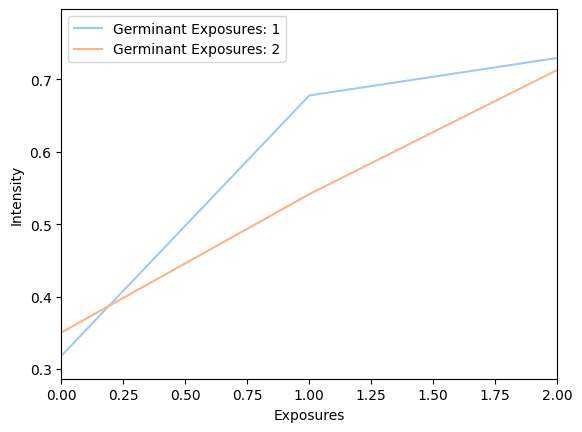


Spores Germinated at Exposure 1 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.38', '0.55', '0.60', '0.67', '0.64', '0.67', '0.68', '0.69', '0.73', '0.72', '0.72', '0.72', '0.35']
Differences Between Means: ['0.17', '0.05', '0.06', '-0.03', '0.04', '0.00', '0.02', '0.04', '-0.02', '0.00', '0.00', '-0.37']

Spores Germinated at Exposure 2 Stats:
Exposures: [11.0, 35.0, 59.0, 83.0, 107.0, 131.0, 155.0, 179.0, 203.0, 227.0, 251.0, 275.0, 0]
Row Means: ['0.40', '0.48', '0.63', '0.70', '0.67', '0.70', '0.71', '0.73', '0.78', '0.74', '0.75', '0.76', '0.38']
Differences Between Means: ['0.08', '0.16', '0.07', '-0.03', '0.03', '0.01', '0.02', '0.05', '-0.03', '0.00', '0.01', '-0.38']


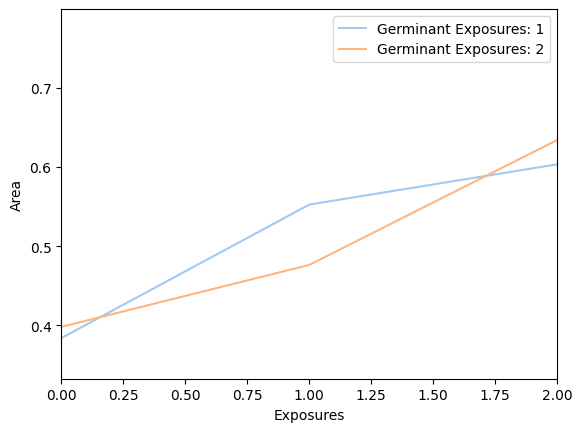

<Figure size 640x480 with 0 Axes>

In [ ]:
def feature_trends_stats(df, feature: str, germinant_exposures: list[int]):
  germinant_exposures.append(0)

  germination_groups = df.groupby("GERMINANT_EXPOSURES")
  num_max_exposures = 0

  #iterate through each group that germinates at a different exposure
  for exposure_number, exposure_group in germination_groups:
    if len(exposure_group) == 1:
      continue

    #get maximum number of exposure to germinate 
    num_max_exposures = max(num_max_exposures, exposure_number)


    #array rows denote each spore value at different exposures, columns are different spores 
    array = np.zeros((len(germinant_exposures), len(exposure_group))) #row is germinant exposure, column is spore index value

    #appends spore values to arrays 
    for spore_index in range(len(exposure_group)):
        spore_feature: list[int] = exposure_group[feature].apply(ast.literal_eval).iloc[spore_index]
        for frame_index in range(min_frames):
          if frame_index in germinant_exposures:
            row_index = germinant_exposures.index(frame_index)
            array[row_index, spore_index] = spore_feature[frame_index]

    row_means = np.mean(array, axis=1)
    diff_between_means = [row_means[i] - row_means[i - 1] for i in range(1, len(row_means))]

    row_medians = np.median(array, axis = 1)
    diff_between_medians = [row_medians[i] - row_medians[i - 1] for i in range(1, len(row_medians))]

    # Truncate to 2 decimal places
    row_means_rounded = [f"{x:.2f}" for x in row_means]
    diff_between_means_rounded = [f"{x:.2f}" for x in diff_between_means]



    # Truncate to 2 decimal places
    row_medians_rounded = [f"{x:.2f}" for x in row_medians]
    diff_between_medians_rounded = [f"{x:.2f}" for x in diff_between_medians]

    print(f"\nSpores Germinated at Exposure {exposure_number} Stats:")
    print(f"Exposures: {germinant_exposures}")
    print(f"Row Means: {row_means_rounded}")
    print(f"Differences Between Means: {diff_between_means_rounded}")

    #print(f"Row Medians: {row_medians_rounded}")
    #print(f"Differences Between Medians: {diff_between_medians_rounded}")
    
    plt.plot(range(len(row_means)), row_means, label = f"Germinant Exposures: {exposure_number}")

  plt.xlim(0, num_max_exposures)
  plt.xlabel("Exposures")
  plt.ylabel(f"{feature[0] + feature[1:].lower()}")
  plt.legend()
  plt.show()
  plt.clf()

feature_trends_stats(df, "INTENSITY", germinant_exposures[:])
feature_trends_stats(df, "AREA", germinant_exposures[:])

### Heatmap of Spore Features over the Population

In [ ]:
def plot_feature_allspores(df, feature_column_title, feature: str):
  plt.clf()
  exp_length = np.min(len(df["GERMINATION"][:]))
     

  df = df.sort_values(by='GERMINATION_INDEX')
  FEATURE_pre = df[feature_column_title].apply(ast.literal_eval).tolist()

  FEATURE = []
  for spore_row in FEATURE_pre:
     FEATURE.append(spore_row[:exp_length])
     
  Z = np.array(FEATURE)


  sns.heatmap(data = Z)#, cmap=plt.cm.viridis)
  for frame in germinant_exposures:
      plt.axvline(x=frame, color='grey', linestyle="dotted", linewidth = 2)
  plt.xlabel("Frame")
  plt.ylabel("Spore Index")
  plt.savefig(f"{plots_folder + feature}.jpg")
  plt.clf()

plot_feature_allspores(df, "INTENSITY", "Intensity")
plot_feature_allspores(df, "AREA", "Area")
plot_feature_allspores(df, "ELLIPSE MINOR", "Minor")
plot_feature_allspores(df, "ELLIPSE MAJOR", "Major")
plot_feature_allspores(df, "PERIMETER", "Perimeter")
plot_feature_allspores(df, "CIRCULARITY", "Circularity")
plot_feature_allspores(df, "ELLIPSE ASPECT RATIO", "AspectRatio")
plot_feature_allspores(df, "GERMINATION", "Germination")

<Figure size 640x480 with 0 Axes>

## Feature Relationships

### Heatmap showing Pearson Correlation Coefficient between Physiological Features

In [ ]:
def feature_heatmap(df, features_list, plot_title, custom_labels, bold_labels):
  '''takes in df in format where each row denotes a spore and each column is a feature and each cell is feature over time in a list'''
  plt.clf()

  correlation_matrices = []

  for spore_index in range(len(df)):
    spore_features = []
    for feature in features_list:
      spore_feature = ast.literal_eval(df.loc[spore_index, feature])
      spore_features.append(spore_feature)
    spore_df = pd.DataFrame(spore_features).T
    spore_df.columns = features_list

    spore_feature_correlation = spore_df.corr()

    correlation_matrices.append(spore_feature_correlation)
  
  avg_correlation_matrix = np.mean(correlation_matrices, axis=0)
  avg_correlation_df = pd.DataFrame(avg_correlation_matrix, index=features_list, columns=features_list)
  avg_correlation_df.rename(columns=custom_labels, index=custom_labels, inplace=True)

  # Plot the heatmap for the average correlation matrix
  plt.figure(figsize = ((14,13)))
  ax = sns.heatmap(avg_correlation_df, annot=True, vmin=-1, vmax=1, cmap="coolwarm", 
                   xticklabels=True, yticklabels=True, annot_kws={"size": 15}, #numbers in heatmap
                   cbar_kws={'label': "$r_{F_1, F_2}$"}, cbar = False)

  ax.set_aspect('equal')

  # Customize tick labels
  tick_font_size = 24

  for tick in ax.get_xticklabels():
      if bold_labels and tick.get_text() in bold_labels:
          tick.set_weight('bold')
      tick.set_fontsize(tick_font_size) #labels size
  
  for tick in ax.get_yticklabels():
      if bold_labels and tick.get_text() in bold_labels:
          tick.set_weight('bold')
      tick.set_fontsize(tick_font_size)
  plt.yticks(rotation=0) 
  plt.xticks(rotation=90) 


      
  #padding between labels and heatmap
  ax.tick_params(axis='x', pad=10)
  ax.tick_params(axis='y', pad=10)

  #colorbar with the same height as the heatmap
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cbar = plt.colorbar(ax.collections[0], cax=cax)

  # Customize colorbar label size
  cbar.ax.tick_params(labelsize=20)
  cbar.ax.yaxis.label.set_size(30)
  cbar.ax.yaxis.label.set_text("Pearson Correlation Coefficient {$r_{F_1, F_2}$}")
  cbar.ax.yaxis.labelpad = 15

  #save
  plt.tight_layout()
  plt.savefig(f"{plots_folder + plot_title}.jpg")
  plt.clf()

  # feature heatmap call 

heatmap_labels = {
  'GERMINATION': 'Germination',
  'INTENSITY': 'Intensity',
  "AREA": "Area",
  "ELLIPSE MINOR": "Ellipse Minor",
  "ELLIPSE MAJOR": "Ellipse Major",
  "PERIMETER": "Perimeter",
  "CIRCULARITY": "Circularity",
  "GERMINANT EXPOSURE": "Germinant Exposure",
  "ELLIPSE ASPECT RATIO": "Ellipse Aspect Ratio"
  }
features = ["GERMINATION", "INTENSITY", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR", "PERIMETER", "CIRCULARITY", "ELLIPSE ASPECT RATIO"]
bold_labels = ["Intensity", "Area", "Ellipse Minor", "Ellipse Major", "Perimeter", "Ellipse Aspect Ratio"]
feature_heatmap(df, features, "Feature Correlations over Time", heatmap_labels, bold_labels)

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1300 with 0 Axes>

## PCA Analysis

In [ ]:
features_list = ["INTENSITY", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR", "PERIMETER"]#, "CIRCULARITY", "ELLIPSE ASPECT RATIO"]
component_num = 2
clusters = 4

In [ ]:
def pca_analysis(df, features_list: list[str], when:str, component_num):
  # Define the list of feature names
  #features_list_when = [when + "_" + feature for feature in features_list]
  #diff_list = ["DIFF_" + feature for feature in features_list]
  #features_list = diff_list + features_list_when

  features_list = [when + "_" + feature for feature in features_list]


  df_features = df[features_list]
  GERMINATION_FRAME = df["GERMINATION_INDEX"]
  GERMINANT_EXPOSURES = df["GERMINANT_EXPOSURES"]
  
  # Standardize the features
  scaler = StandardScaler()
  scaled_features = scaler.fit_transform(df_features)

  # pca
  pca = PCA(n_components=component_num)
  principal_components = pca.fit_transform(scaled_features)
  pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(component_num)])
  # Combine PCA results with germination frame
  pc_df = pd.concat([pc_df, GERMINATION_FRAME.reset_index(drop=True), GERMINANT_EXPOSURES.reset_index(drop=True)], axis=1)

  # 2 pca components
  if component_num == 2:
    sns.scatterplot(x='PC1', y='PC2', hue='GERMINANT_EXPOSURES', data=pc_df, palette='pastel')
    plt.title(f'PCA of {experiment} with Germination Frame')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc = "best", title = "Exposures")
    plt.show()

  if component_num == 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c=GERMINATION_FRAME, cmap='viridis', s=100, alpha=0.7)
    legend = ax.legend(*scatter.legend_elements(), title='Cluster')
    ax.add_artist(legend)
    ax.set_title('K-means Clustering')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()

  # Explained variance ratio
  print('Explained variance ratio:', pca.explained_variance_ratio_)

  # Loadings
  feature_weights = pca.components_
  feature_weights_df = pd.DataFrame(feature_weights, columns=features_list, index=["PC" + str(i) for i in range(component_num)])
  #print(loadings_df)

  # Correlation analysis
  correlation_matrix = pc_df.corr()
  print(correlation_matrix)

  plt.tight_layout()
  plt.show()

  #pc_df.to_csv(f'{data_folder}pca_principalcomponents_{when.lower()}features_pc={component_num}.csv', index=False)
  feature_weights_df.to_csv(f'{data_folder}pca_featureweights_{when.lower()}features_pc={component_num}.csv', index=True)
  correlation_matrix.to_csv(f'{data_folder}pca_corr_{when.lower()}features_pc={component_num}.csv', index=True)
  return pc_df, df_features

In [ ]:
def elbow_method(df):
  wcss = []
  for i in range(1, 11):
      kmeans = KMeans(n_clusters=i)
      kmeans.fit(df[['PC1', 'PC2']])
      wcss.append(kmeans.inertia_)

  plt.figure(figsize=(5, 3.5))
  plt.plot(range(1, 11), wcss, marker='o')
  plt.title('Elbow Method for Optimal Number of Clusters')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.show()    

In [ ]:
def cluster_kmeans(df, n:int):
  kmeans = KMeans(n_clusters=n)  # You can choose the number of clusters (e.g., 3)
  kmeans.fit(df)
  df['Cluster'] = kmeans.labels_

  # scatter plot
  sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='pastel', s=100, alpha=0.7)
  plt.title('K-means Clustering on PCA Results')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.legend(title='Cluster')
  plt.show()
  return kmeans, df
def cluster_stats(kmeans, pca_df, df_features, features_list, when, n, component_nums):
    # features_list_when = [when + "_" + feature for feature in features_list]
    # diff_list = ["DIFF_" + feature for feature in features_list]
    # features_list = diff_list + features_list_when
    features_list = [when + "_" + feature for feature in features_list]

    
    centroids = kmeans.cluster_centers_

    # Add the cluster labels to the original data
    df_features.loc[:, 'Cluster'] = kmeans.labels_

    # Compute validation metrics for clsutering effectiveness
    silhouette_avg = silhouette_score(pca_df.iloc[:, :n], pca_df['Cluster'])
    db_score = davies_bouldin_score(pca_df.iloc[:, :n], pca_df['Cluster'])
    # Save validation metrics to a CSV file
    validation_metrics_df = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Index'],
        'Value': [silhouette_avg, db_score]
    })
    validation_metrics_df.to_csv(f'{data_folder}pca_validation_metrics_{when.lower()}features_pc={component_nums}_clusternum={n}.csv', index=False)


    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Index: {db_score}')

    # Analyze cluster centroids
    print("Cluster Centroids:")
    print(centroids)
    centroids_df = pd.DataFrame(centroids, columns=pca_df.columns[:-1])
    centroids_df.to_csv(f'{data_folder}pca_clustercentroids_{when.lower()}features_pc={component_nums}clusternum={n}.csv', index=False)


    # summary for clusters
    summary_stats_list = []
    for cluster in range(n):
        #print(f"\nCluster {cluster} Summary Statistics:")
        cluster_data = df_features[df_features['Cluster'] == cluster]
        summary_stats = cluster_data.describe().reset_index()
        summary_stats['Cluster'] = cluster
        summary_stats_list.append(summary_stats)
        #print(cluster_data.describe())
        
    #summary to csv
    summary_stats_df = pd.concat(summary_stats_list, axis=0)
    summary_stats_df.to_csv(f"{data_folder}pca_clusterstats_{when.lower()}features_pc={component_nums}clusternum={n}.csv", index=False)

    ### BOX PLOT
    #sns.pairplot(df_features, hue='Cluster', palette='pastel')

    for feature in features_list:
        plt.figure(figsize=(6, 3.5))
        #sns.boxplot(x='Cluster', y=feature, data=df_features, palette="pastel")
        sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")
        #sns.swarmplot(x='Cluster', y=feature, data=df_features, palette="pastel")
        #sns.stripplot(x='Cluster', y=feature, data=df_features, palette="pastel", jitter=True)

        feature_label = feature.replace("_", " ").title()
        plt.title(f'{feature_label} by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel(feature)
        plt.show()
        plt.clf()


def correlation_cluster_germination(df_features):
    # Calculate correlation
    correlation_pearson, _ = pearsonr(df_features['Cluster'], df_features['GERMINATION_INDEX'])
    correlation_spearman, _ = spearmanr(df_features['Cluster'], df_features['GERMINATION_INDEX'])
    print(f'Pearson Correlation: {correlation_pearson}')
    print(f'Spearman Correlation: {correlation_spearman}')
    
    #scatter cluster by germination
    plt.figure(figsize=(5, 3.5))
    sns.scatterplot(x='Cluster', y='GERMINATION_INDEX', data=df_features, palette='pastel', s=100, alpha=0.7, hue = "Cluster")
    plt.title('Scatter Plot of Germination Index by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Germination Index')
    plt.show()
def plot_radar(data, features, clusters, title='Radar Chart of Clusters'):
    
    labels = np.array(features)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    angles += angles[:1]
    sns.set_palette("pastel")

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

    for cluster in clusters:
        stats = data.loc[cluster].values
        stats = np.concatenate((stats, [stats[0]]))
        ax.plot(angles, stats, linewidth=2, label=f'Cluster {cluster}')
        #ax.plot(angles, stats, linewidth=2, label=f'Cluster {cluster}')

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()


### Initial Values

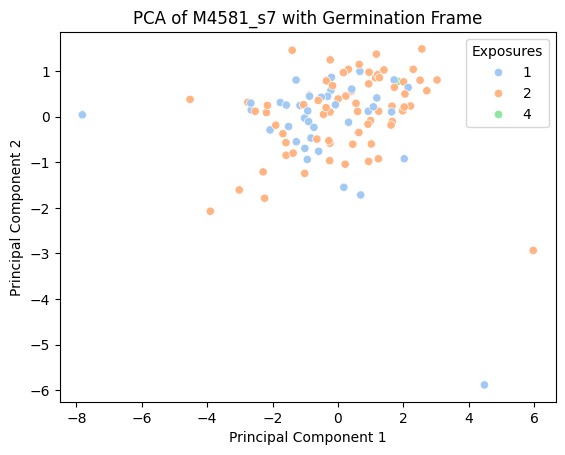

Explained variance ratio: [0.67698675 0.18995388]
                              PC1           PC2  GERMINATION_INDEX  \
PC1                  1.000000e+00 -1.117586e-16           0.174879   
PC2                 -1.117586e-16  1.000000e+00           0.135096   
GERMINATION_INDEX    1.748786e-01  1.350961e-01           1.000000   
GERMINANT_EXPOSURES  1.773296e-01  1.303713e-01           0.999161   

                     GERMINANT_EXPOSURES  
PC1                             0.177330  
PC2                             0.130371  
GERMINATION_INDEX               0.999161  
GERMINANT_EXPOSURES             1.000000  


<Figure size 640x480 with 0 Axes>

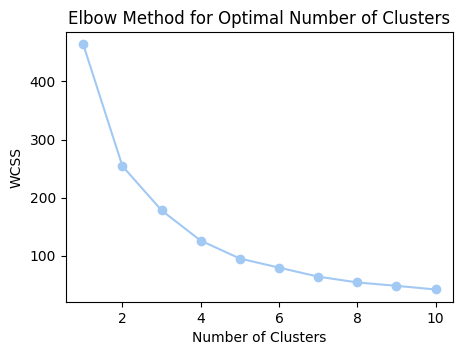

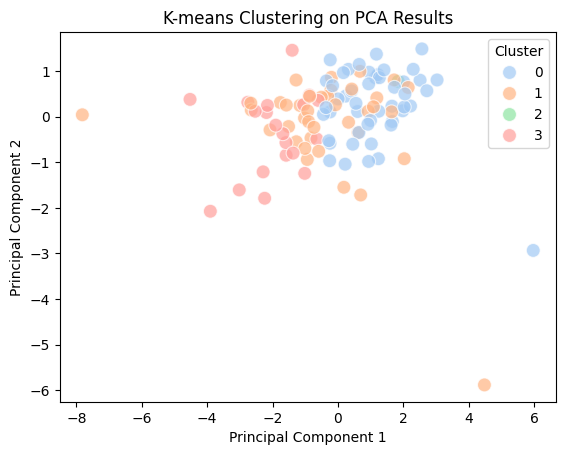

Silhouette Score: 0.6046869425812761
Davies-Bouldin Index: 0.4485713670380468
Cluster Centroids:
[[ 1.08860438  0.25658091 37.08333333  2.        ]
 [-0.38852316 -0.1481604  13.28947368  1.        ]
 [ 1.84304091  0.7774807  86.          4.        ]
 [-1.96660857 -0.37316344 37.25        2.        ]]


/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/2942823619.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_init["GERMINATION_INDEX"] = df["GERMINATION_INDEX"]
/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.loc[:, 'Cluster'] = kmeans.labels_
/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is

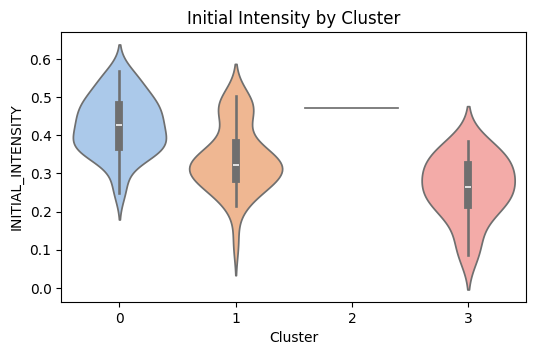

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

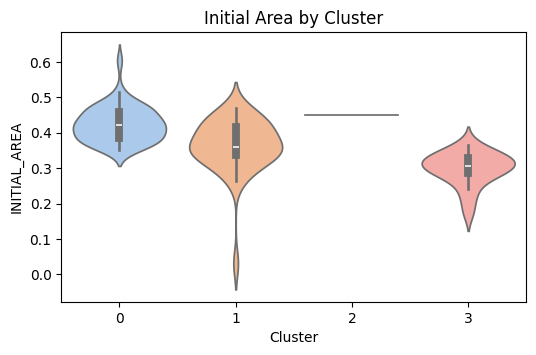

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

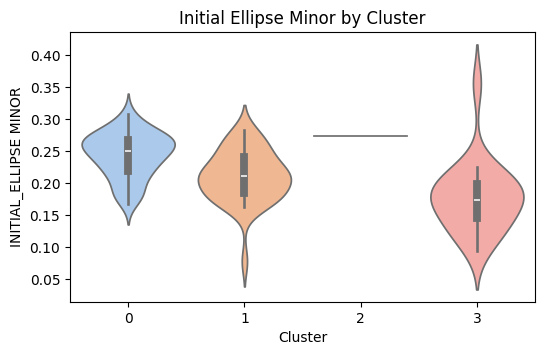

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

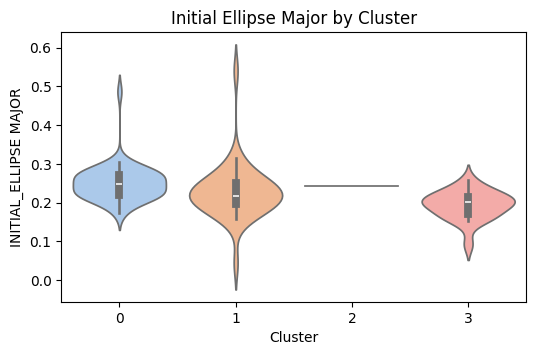

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

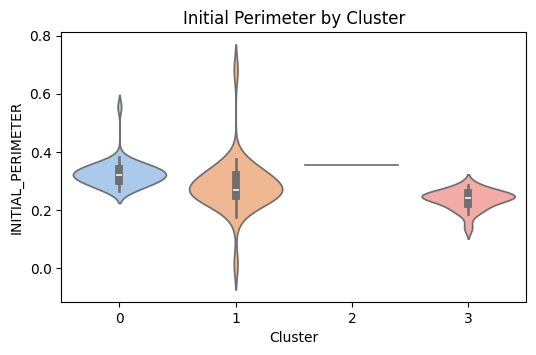

Pearson Correlation: -0.00010070789901251403
Spearman Correlation: -0.3015365739490267


<Figure size 640x480 with 0 Axes>

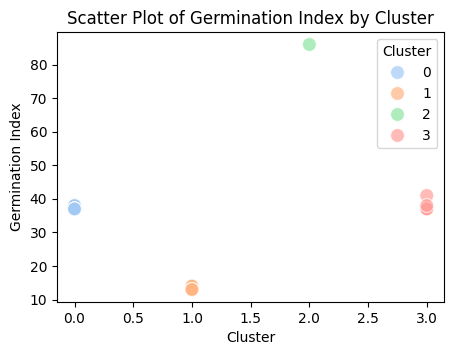

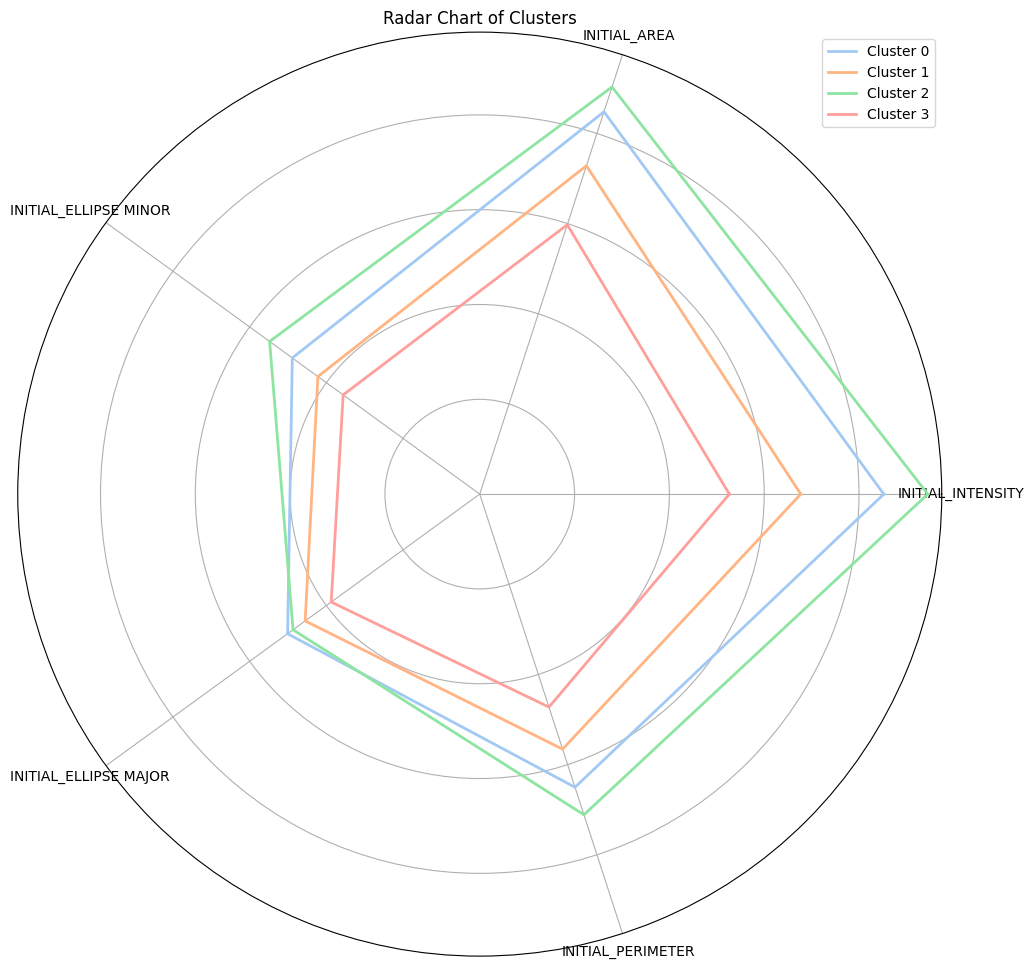

In [ ]:
pca_df_init, df_features_init = pca_analysis(df, features_list, "INITIAL", component_num)
elbow_method(pca_df_init)
kmeans_init, pca_df_clusters_init = cluster_kmeans(pca_df_init, clusters)
df_features_init["GERMINATION_INDEX"] = df["GERMINATION_INDEX"]
cluster_stats(kmeans_init, pca_df_clusters_init, df_features_init, features_list, "INITIAL", clusters, component_num)
correlation_cluster_germination(df_features_init)
features_list_init = [f"INITIAL_{feature}" for feature in features_list]
mean_values = df_features_init.groupby('Cluster')[features_list_init].mean()

# Plot the radar chart with overlayed clusters
plot_radar(mean_values, features_list_init, clusters=mean_values.index)


### Last Values before Germination

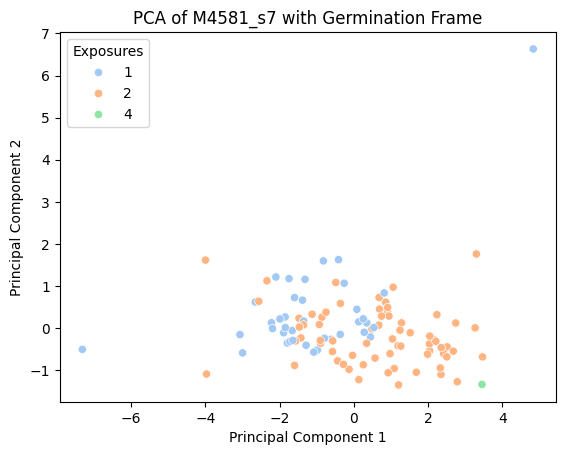

Explained variance ratio: [0.71338389 0.17516188]
                              PC1           PC2  GERMINATION_INDEX  \
PC1                  1.000000e+00 -1.364891e-16           0.468535   
PC2                 -1.364891e-16  1.000000e+00          -0.323009   
GERMINATION_INDEX    4.685348e-01 -3.230088e-01           1.000000   
GERMINANT_EXPOSURES  4.698265e-01 -3.182906e-01           0.999161   

                     GERMINANT_EXPOSURES  
PC1                             0.469827  
PC2                            -0.318291  
GERMINATION_INDEX               0.999161  
GERMINANT_EXPOSURES             1.000000  


<Figure size 640x480 with 0 Axes>

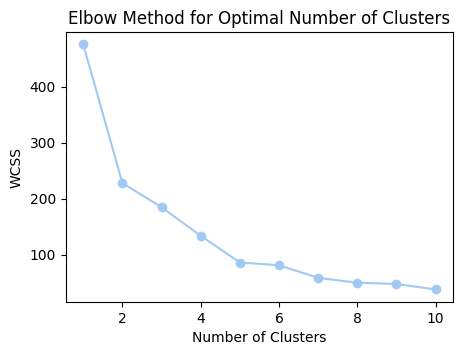

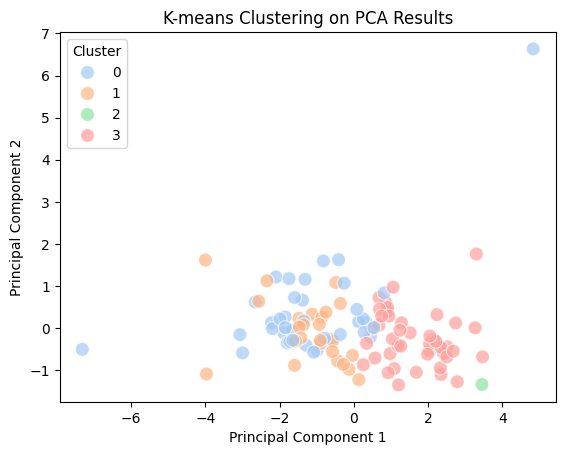

Silhouette Score: 0.6252604071679048
Davies-Bouldin Index: 0.4075659203543309
Cluster Centroids:
[[-1.13901512e+00  3.72799242e-01  1.32894737e+01  1.00000000e+00]
 [-1.20021302e+00 -8.41937497e-02  3.71200000e+01  2.00000000e+00]
 [ 3.44829353e+00 -1.33925255e+00  8.60000000e+01  4.00000000e+00]
 [ 1.62417690e+00 -2.49355230e-01  3.71395349e+01  2.00000000e+00]]


/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/2453108543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_last["GERMINATION_INDEX"] = df["GERMINATION_INDEX"]
/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.loc[:, 'Cluster'] = kmeans.labels_
/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is

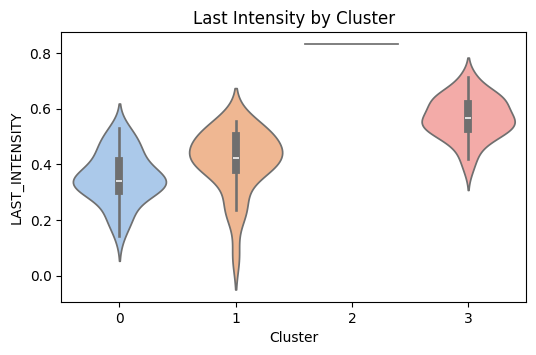

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

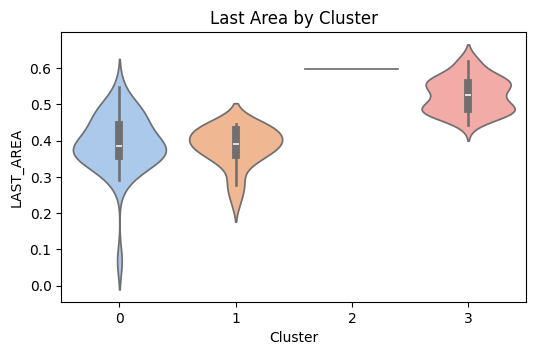

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

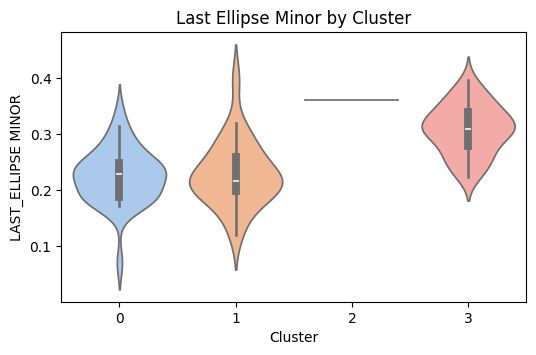

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

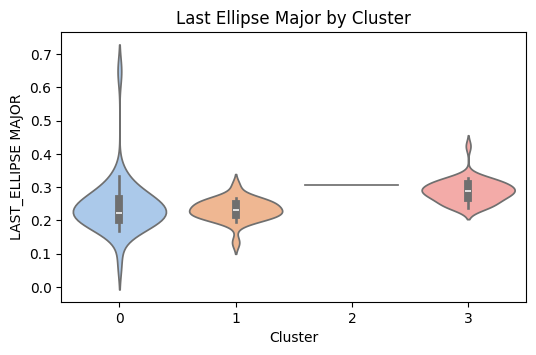

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

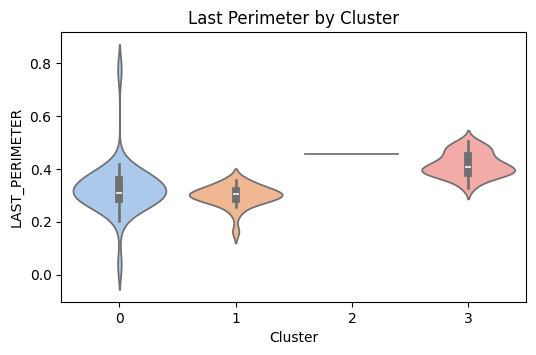

Pearson Correlation: 0.7495994393895921
Spearman Correlation: 0.811931679123392


<Figure size 640x480 with 0 Axes>

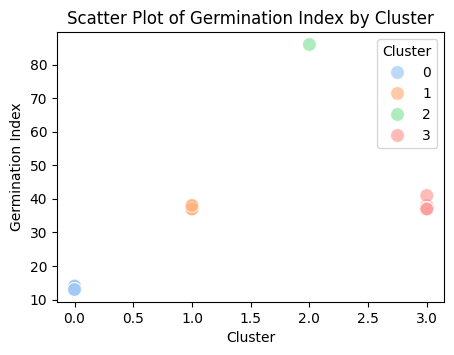

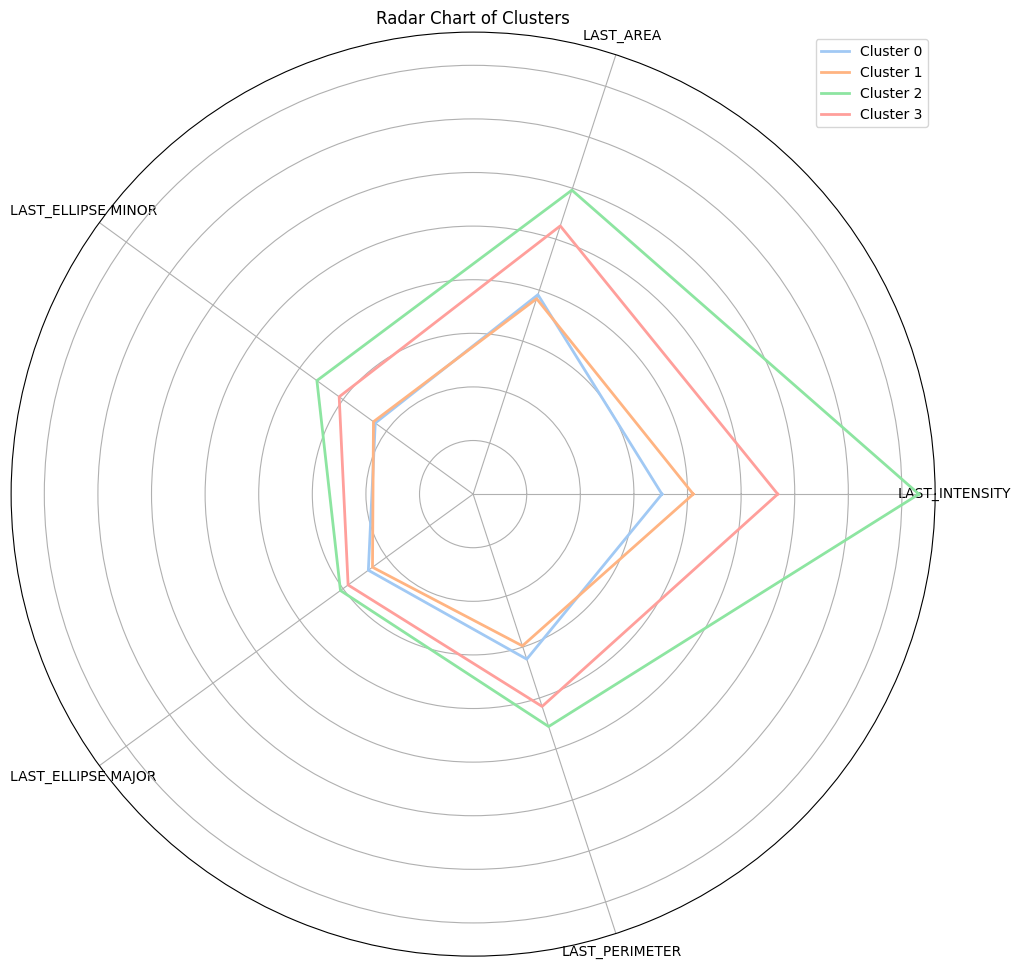

In [ ]:
pca_df_last, df_features_last = pca_analysis(df, features_list, "LAST", component_num)
elbow_method(pca_df_last)
kmeans_last, pca_df_clusters_last = cluster_kmeans(pca_df_last, clusters)
df_features_last["GERMINATION_INDEX"] = df["GERMINATION_INDEX"]
cluster_stats(kmeans_last, pca_df_clusters_last, df_features_last, features_list, "LAST", clusters, component_num)
correlation_cluster_germination(df_features_last)
features_list_last = [f"LAST_{feature}" for feature in features_list]
mean_values = df_features_last.groupby('Cluster')[features_list_last].mean()

# Normalize the feature values (optional)
# scaler = MinMaxScaler()
# normalized_values = scaler.fit_transform(mean_values)
# normalized_values = pd.DataFrame(normalized_values, columns=mean_values.columns, index=mean_values.index)

# Plot the radar chart with overlayed clusters
plot_radar(mean_values, features_list_last, clusters=mean_values.index)


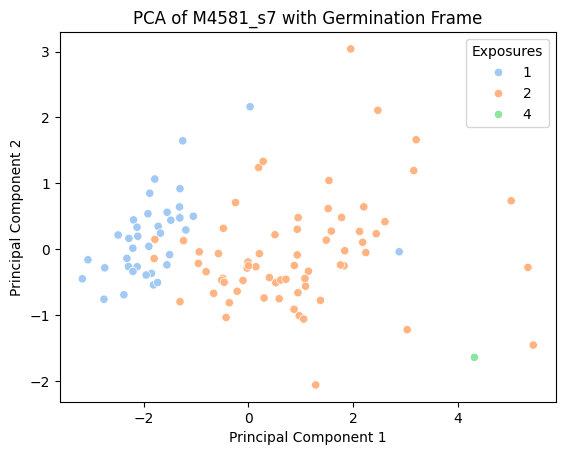

Explained variance ratio: [0.71086615 0.11736511]
                              PC1           PC2  GERMINATION_INDEX  \
PC1                  1.000000e+00  1.020191e-16           0.710649   
PC2                  1.020191e-16  1.000000e+00          -0.243457   
GERMINATION_INDEX    7.106490e-01 -2.434574e-01           1.000000   
GERMINANT_EXPOSURES  7.068445e-01 -2.384220e-01           0.999161   

                     GERMINANT_EXPOSURES  
PC1                             0.706845  
PC2                            -0.238422  
GERMINATION_INDEX               0.999161  
GERMINANT_EXPOSURES             1.000000  


<Figure size 640x480 with 0 Axes>

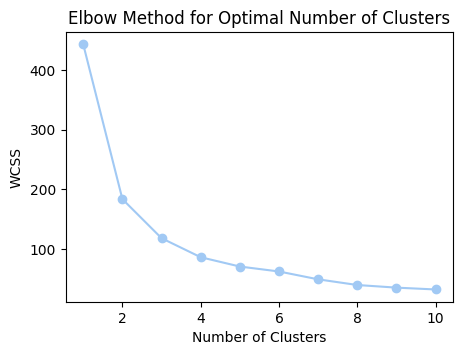

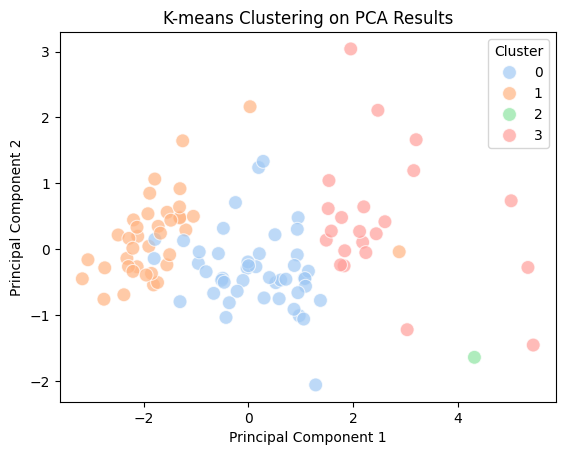

Silhouette Score: 0.6205211733417385
Davies-Bouldin Index: 0.47908369725417094
Cluster Centroids:
[[ 0.12235944 -0.32242617 37.08695652  2.        ]
 [-1.75586826  0.1853335  13.28947368  1.        ]
 [ 4.31860346 -1.64294639 86.          4.        ]
 [ 2.58072072  0.42872168 37.22727273  2.        ]]


/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/2089283034.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_diff["GERMINATION_INDEX"] = df["GERMINATION_INDEX"]
/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.loc[:, 'Cluster'] = kmeans.labels_
/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is

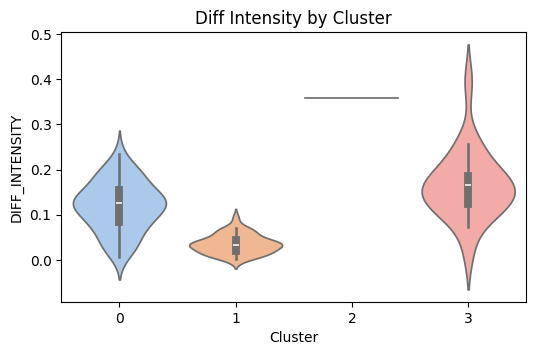

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

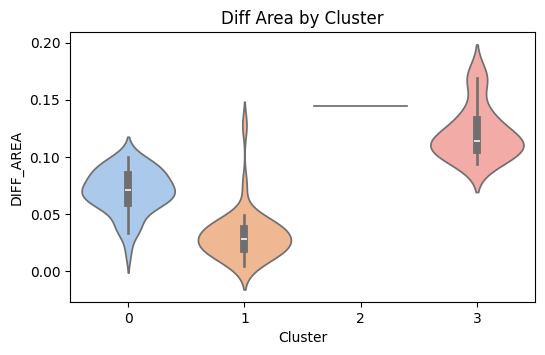

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

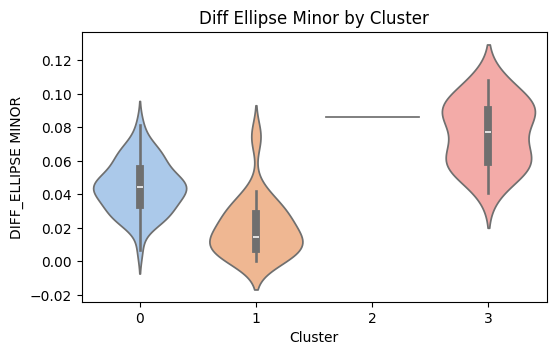

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

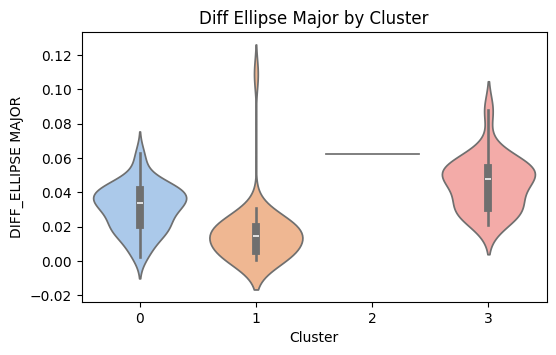

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_55946/3742427430.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Cluster', y=feature, data=df_features, palette="pastel")


<Figure size 640x480 with 0 Axes>

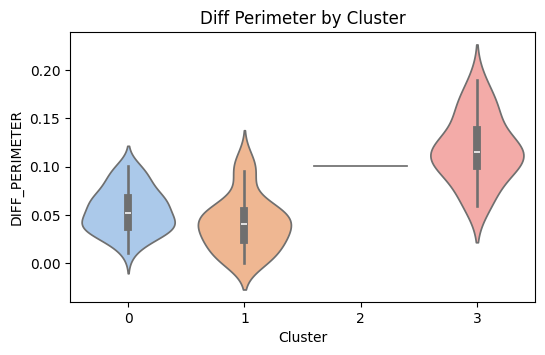

Pearson Correlation: 0.030968285671143427
Spearman Correlation: -0.2583061287534961


<Figure size 640x480 with 0 Axes>

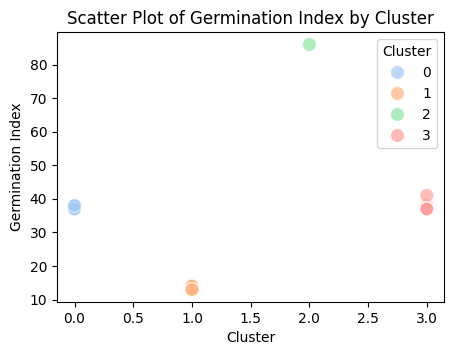

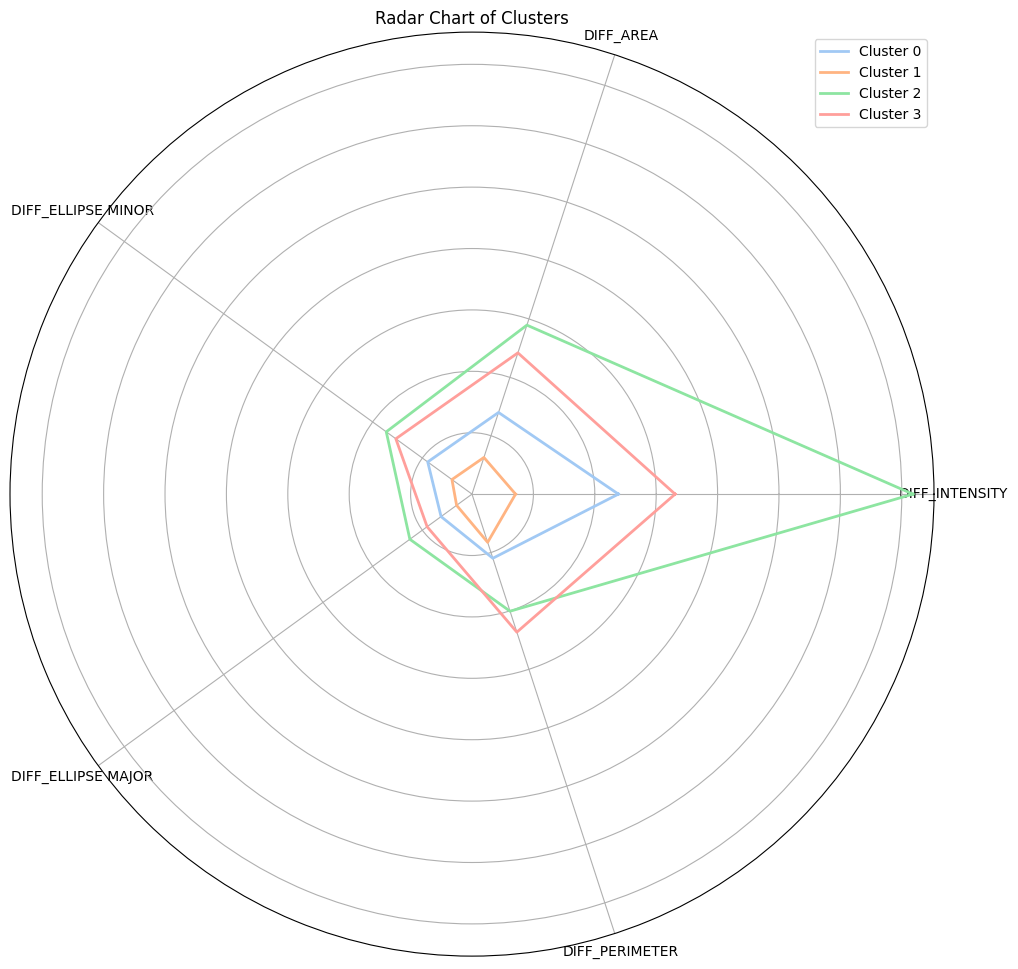

In [ ]:
pca_df_diff, df_features_diff = pca_analysis(df, features_list, "DIFF", component_num)
elbow_method(pca_df_diff)
kmeans_diff, pca_df_clusters_diff = cluster_kmeans(pca_df_diff, clusters)
df_features_diff["GERMINATION_INDEX"] = df["GERMINATION_INDEX"]
cluster_stats(kmeans_diff, pca_df_clusters_diff, df_features_diff, features_list, "DIFF", clusters, component_num)
correlation_cluster_germination(df_features_diff)
features_list_diff = [f"DIFF_{feature}" for feature in features_list]
mean_values = df_features_diff.groupby('Cluster')[features_list_diff].mean()

# Plot the radar chart with overlayed clusters
plot_radar(mean_values, features_list_diff, clusters=mean_values.index)


## LDA Analysis

In [ ]:
features_list = ["INTENSITY", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR", "PERIMETER", "CIRCULARITY", "ELLIPSE ASPECT RATIO"]

[[-1.01791219  0.48205239 -1.31854178]
 [-0.89734271 -0.40198998  0.1768032 ]
 [-0.45030841 -3.25128087 -1.75351906]
 [-0.14634624 -0.54227567 -1.62690902]
 [ 0.57661638  0.89789108 -1.45250102]
 [ 1.03080181 -0.68327492  1.78799579]
 [-0.73417052  0.52337881  0.96087987]
 [-0.36764641 -0.69360903 -2.34989802]
 [-1.96772808  0.17487416  0.48069137]
 [-0.41208488  0.34291545  0.333806  ]
 [-0.78365972  0.98734384  0.36961853]
 [-1.96215557  1.1192461   0.87503553]
 [ 0.60710881 -1.69277078  1.42288747]
 [-0.67133418 -0.32221804 -1.04912575]
 [-1.82228125  0.43618403  0.73328481]
 [ 0.87761205 -1.59428512  1.45538101]
 [-0.53855589  0.15660269  1.79994154]
 [ 0.79844034  1.0085397   0.97333757]
 [ 1.08748522  1.78685674 -0.13849519]
 [-1.82941903 -0.14527405  1.28409725]
 [ 0.60138127 -1.00914883 -1.74364271]
 [-1.27959976 -0.43167319  1.39125358]
 [ 0.15008039 -1.38517318 -1.56868208]
 [ 0.43650551 -1.47229748  1.3429464 ]
 [ 1.56568474  0.12270491  1.19282355]
 [-0.56619894 -0.31826056

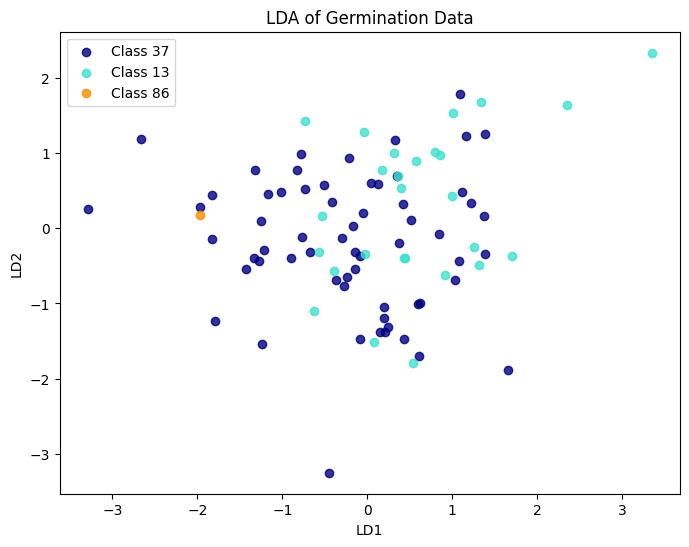

In [ ]:
def lda_analysis(df, features_list, when: int):
  Y = df["GERMINATION_INDEX"]
  features_list = [when + "_" + feature for feature in features_list]
  X = df[features_list]

  lda = LDA(n_components = 3)
  X_lda = lda.fit_transform(X, Y)

  print(X_lda)
  # Plot the results
  plt.figure(figsize=(8, 6))
  colors = ['navy', 'turquoise', 'darkorange']
  lw = 2

  unique_classes = Y.unique()
  for color, i in zip(colors, unique_classes):
      plt.scatter(X_lda[Y == i, 0], X_lda[Y == i, 1], alpha=.8, color=color, label=f'Class {i}')
  plt.xlabel('LD1')
  plt.ylabel('LD2')
  plt.legend(loc='best')
  plt.title('LDA of Germination Data')
  plt.show()
  plt.show()
lda_analysis(df, features_list, "INITIAL")